<a href="https://colab.research.google.com/github/janduplessis883/Cervical-Screening-Self-Book-with-Accurx/blob/main/CxScreeningTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cervical Screening Self-Book with Accurx
**The introduction of SMS interventions at participating practices appears to have correlated with an immediate spike in cervical screenings, suggesting an effective strategy for increasing health engagement, though further analysis is necessary to confirm long-term efficacy and causation.**

Interpreting the plots, it appears to show two key data trends over time: the number of female registrations aged 24-64 years and the monthly cervical screening count at participating practices. The vertical dashed red line indicates the start of an intervention using SMS (text messaging), which began on October 12, 2023. for ECS and Nov,1 2023 for the TCP and SMW.

### Here's what we can discern from the charts:

**Before the Intervention:** Prior to the SMS intervention, there is a fluctuating but generally consistent gap between female registrations and the number of cervical screenings. This suggests a variance in the uptake of cervical smear tests among those registered.

**After the Intervention:** There is a significant spike in the number of cervical screenings in the month following the start of the SMS intervention, indicating a potential positive impact of the SMS reminders on the uptake of cervical smear tests. This peak is the highest point on the graph for the monthly cervical screening count, suggesting that the SMS intervention might have been effective in encouraging more women to undergo screening.

**Statistical Summary:** The mean monthly cervical screening rate before the intervention is noted as 29.58, and the mean monthly registrations for females in the cervical screening age group is 17.12. The mean difference of 12.46 could reflect the average gap between registrations and screenings conducted each month.

It’s important to note that while the immediate increase in screenings after the start of the SMS intervention suggests a correlation, further analysis would be required to establish causation. This would include looking at longer-term trends, ruling out other factors that might have influenced the spike, and potentially comparing with a control group.

Additionally, the sharp decline in screenings right after the peak might indicate that while the SMS intervention had an initial impact, its effect may not have been sustained over time, or it could be due to other factors not visible on this graph, such as seasonal variations or operational issues at the practice. A careful examination of the full context of the data and additional data points beyond the scope of this graph would be needed for a comprehensive understanding.
### Post Intervention Patient Survey
We care currently collecting patient feedback to aid furhter analysis.<BR>
[Patient Survery Questionnaire](https://docs.google.com/forms/d/e/1FAIpQLSc_iWioKWfGq01BLFWX47sINgZhDGwaspM3yo0ewbQUES3FMw/viewform)

### Importing Libraries & Loading Data
Data extracted from SystmOne and served to Colabs Notebook via a Google Sheet.
Two dataframes prepared, on with Cervical Screening `data` and `reg` for Registration data for the corresponding cohort of patients.

In [16]:
# @title
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

In [17]:
# @title
creds, _ = default()

gc = gspread.authorize(creds)

# Open the Google Spreadsheet and specify the sheet name
spreadsheet = gc.open('Cx Screening')
worksheet = spreadsheet.worksheet('Sheet1')

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# print(rows)

# Convert to a DataFrame and render.
import pandas as pd
data = rows[1:]
columns = rows[0]
data = pd.DataFrame(data, columns=columns)

display(data.head())
print(data.shape)

,Patient ID,Event date,Event done by,Surgery
0,37858269,13-Mar-2023,"HUNT, Elaine (Ms)",SMW
1,47744204,28-Apr-2023,"FARMERY, Louise (Ms)",SMW
2,20021999,24-Aug-2023,"FARMERY, Louise (Ms)",SMW
3,28847526,8-Feb-2023,"HUNT, Elaine (Ms)",SMW
4,24954944,2-Oct-2023,"FARMERY, Louise (Ms)",SMW


(4018, 4)


In [18]:
# @title
data['Event date'] = pd.to_datetime(data['Event date'], format='%d-%b-%Y')

In [19]:
# @title
# Open the Google Spreadsheet and specify the sheet name
spreadsheet = gc.open('Cx Screening')
worksheet = spreadsheet.worksheet('Sheet2')

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
# print(rows)

# Convert to a DataFrame and render.
import pandas as pd
reg = rows[1:]
columns = rows[0]
reg = pd.DataFrame(reg, columns=columns)

display(reg.head())
print(reg.shape)

,Age in years,Postcode Latitude,Postcode Longitude,Deduction date,Registration date,Patient ID,Surgery
0,25,51.4895,-0.165998,,7-Aug-2023,56913599,TCP
1,25,51.4914,-0.167994,,31-Mar-2023,2008199,TCP
2,26,51.4843,-0.168194,,3-Feb-2023,45989044,TCP
3,26,51.4863,-0.162726,,14-Nov-2022,54759348,TCP
4,27,51.4852,-0.163042,,4-May-2023,18556815,TCP


(8543, 7)


In [35]:
reg.isna().sum()

Age in years          0
Postcode Latitude     2
Postcode Longitude    2
Deduction date        0
Registration date     0
Patient ID            0
Surgery               0
dtype: int64

In [36]:
# @title
import numpy as np

reg['Postcode Latitude'].replace('', np.nan, inplace=True)
reg['Postcode Longitude'].replace('', np.nan, inplace=True)

reg['Postcode Latitude'] = reg['Postcode Latitude'].astype(float)
reg['Postcode Longitude'] = reg['Postcode Longitude'].astype(float)

reg.dropna(inplace=True)


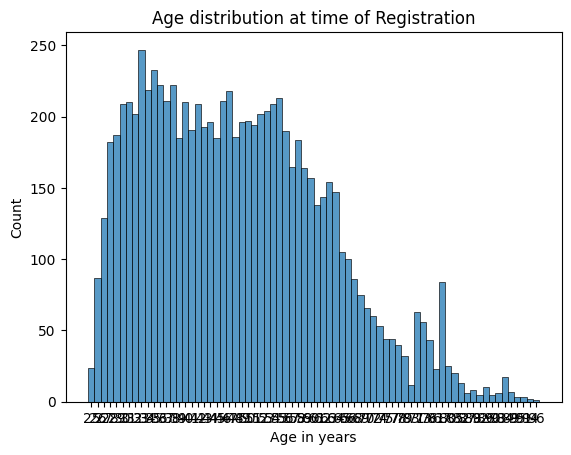

In [20]:
# @title
sns.histplot(reg['Age in years'], bins=20);
plt.title("Age distribution at time of Registration");

In [21]:
# @title
reg['Registration date'] = pd.to_datetime(reg['Registration date'], format='%d-%b-%Y')
data['Event date'] = pd.to_datetime(data['Event date'], format='%d-%b-%y')
reg = reg[(reg['Registration date'] > '2020-12-31')]
data = data[(data['Event date'] > '2020-12-31')]

In [49]:
# @title
def to_timeseries(df, column):
    m_count = df.resample("M", on=column).size()
    m_count_df = m_count.reset_index()
    m_count_df.columns = ["Date", "Monthly Count"]
    return m_count_df

data_ts = to_timeseries(data, 'Event date')
reg_ts = to_timeseries(reg, 'Registration date')

In [50]:
# @title
def plot_ts(reg_df, cx_df, title, h_date='2023-11-01', surgery=['ECS', 'TCP', 'SMW'], color='#4294c2'):

    for s in surgery:

        # Prepare surgery data
        data_df2 = cx_df[(cx_df['Surgery'].isin(surgery))]
        reg_df2 = reg_df[(reg_df['Surgery'].isin(surgery))]

    data3 = to_timeseries(data_df2, 'Event date')
    reg3 = to_timeseries(reg_df2, 'Registration date')

    # Define the date to highlight
    date_to_highlight = h_date

    # Convert the date string to a numeric value
    date_to_highlight_numeric = mdates.datestr2num(date_to_highlight)

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(20, 4))

    # Plot the lineplot
    sns.lineplot(data=reg3, x='Date', y='Monthly Count', color='#4775a7', linewidth=0.3, label='Female Registrations 24 - 64 yrs ')
    sns.lineplot(data=data3, x='Date', y='Monthly Count', color=color, linewidth=2, label='Monthly Cx Screening')

    # Add horizontal gridlines
    ax.yaxis.grid(True, linestyle="--", linewidth=0.3, color="#888888")
    ax.xaxis.grid(True, linestyle="--", linewidth=0.3, color="#888888")



    # Add the vertical red line
    ax.axvline(x=date_to_highlight_numeric, color='#ae4f4d', linestyle='--', label='Accurx Trail Started 12-Oct-2023')

    # Remove the top, right, and left spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set the title
    plt.title(title)

    # Set x-axis ticks every second month
    locator = mdates.MonthLocator(interval=2)  # Specify the interval
    formatter = mdates.DateFormatter("%b %Y")  # Format for x-axis labels
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # Show the legend
    plt.legend()

    # Show the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()
    print(f"Mean Monthly {surgery} - Cx Screening Rate: {round(data3['Monthly Count'].mean(), 2)}")
    print(f"Mean Monthly {surgery} - Registrations for Females in the Cx Screening Age-group: {round(reg3['Monthly Count'].mean(), 2)}")
    print(f"Mean Diff:  {round(data3['Monthly Count'].mean() - reg3['Monthly Count'].mean(), 2)} - Effectiveness of Screening Program")

# Collective Monthly Count for **ECS + TCP + SMW**
On average, Cx screens outnumber new patient registrations by **23.47**.

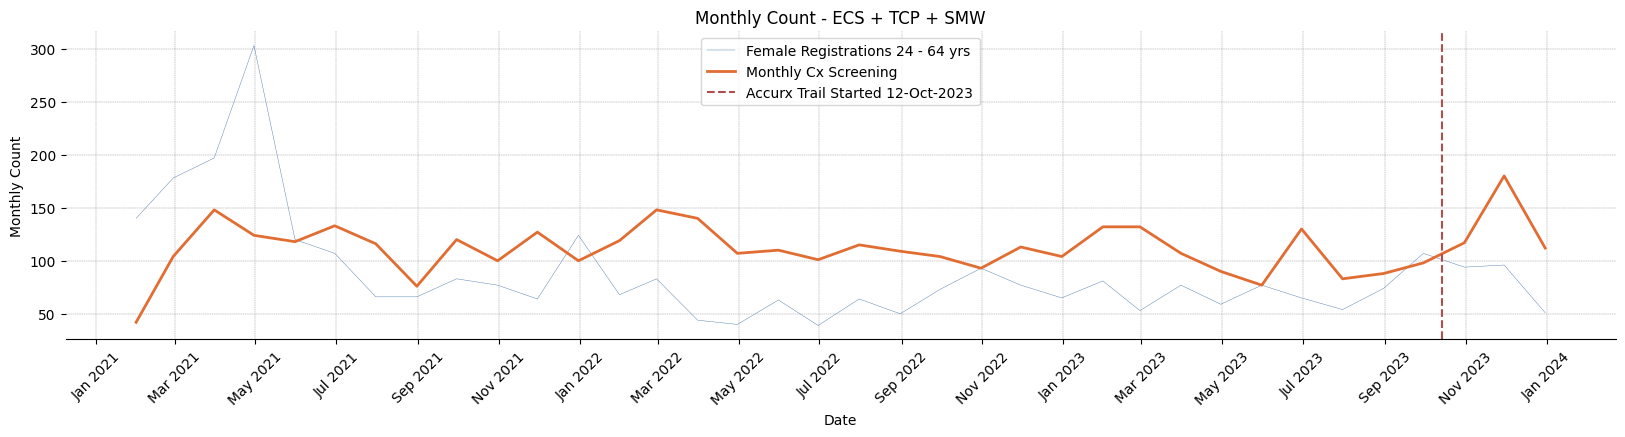

Mean Monthly ['ECS', 'TCP', 'SMW'] - Cx Screening Rate: 111.58
Mean Monthly ['ECS', 'TCP', 'SMW'] - Registrations for Females in the Cx Screening Age-group: 88.11
Mean Diff:  23.47 - Effectiveness of Screening Program


In [45]:
plot_ts(reg, data, "Monthly Count - ECS + TCP + SMW", h_date='2023-10-14', color='#e16d33')

# Monthly Count - **Earls Court Surgery**
On average, Cx screens outnumber new patient registrations by **4.74**.

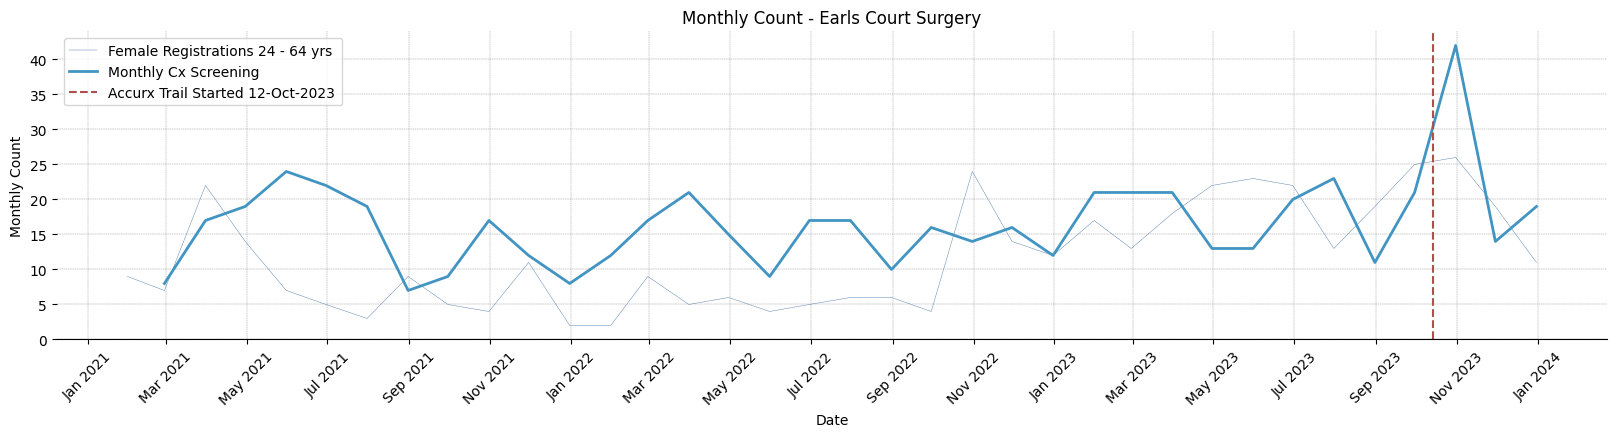

Mean Monthly ['ECS'] - Cx Screening Rate: 16.49
Mean Monthly ['ECS'] - Registrations for Females in the Cx Screening Age-group: 11.75
Mean Diff:  4.74 - Effectiveness of Screening Program


In [46]:
plot_ts(reg, data, "Monthly Count - Earls Court Surgery", h_date='2023-10-14', surgery=["ECS"])

# Monthly Count - **The Chelsea Practice**
On average, Cx screens outnumber new patient registrations by **5.89**.

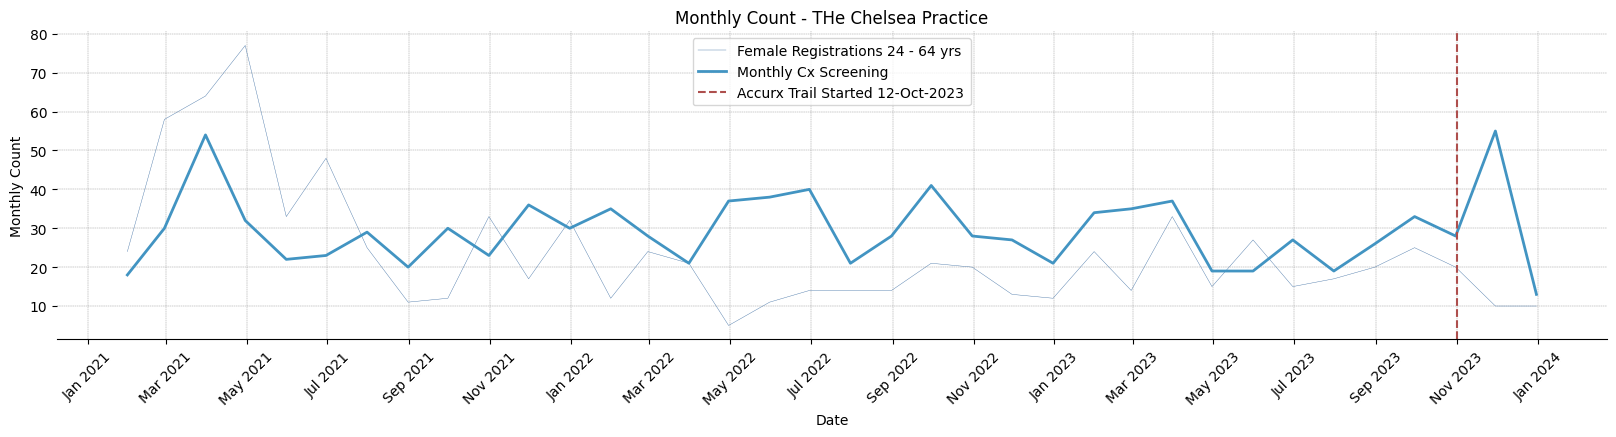

Mean Monthly ['TCP'] - Cx Screening Rate: 29.36
Mean Monthly ['TCP'] - Registrations for Females in the Cx Screening Age-group: 23.47
Mean Diff:  5.89 - Effectiveness of Screening Program


In [47]:
plot_ts(reg, data, "Monthly Count - THe Chelsea Practice", surgery=["TCP"])

# Monthly Count - **Stanhope Mews West**
On average, Cx screens outnumber new patient registrations by **13.31**.

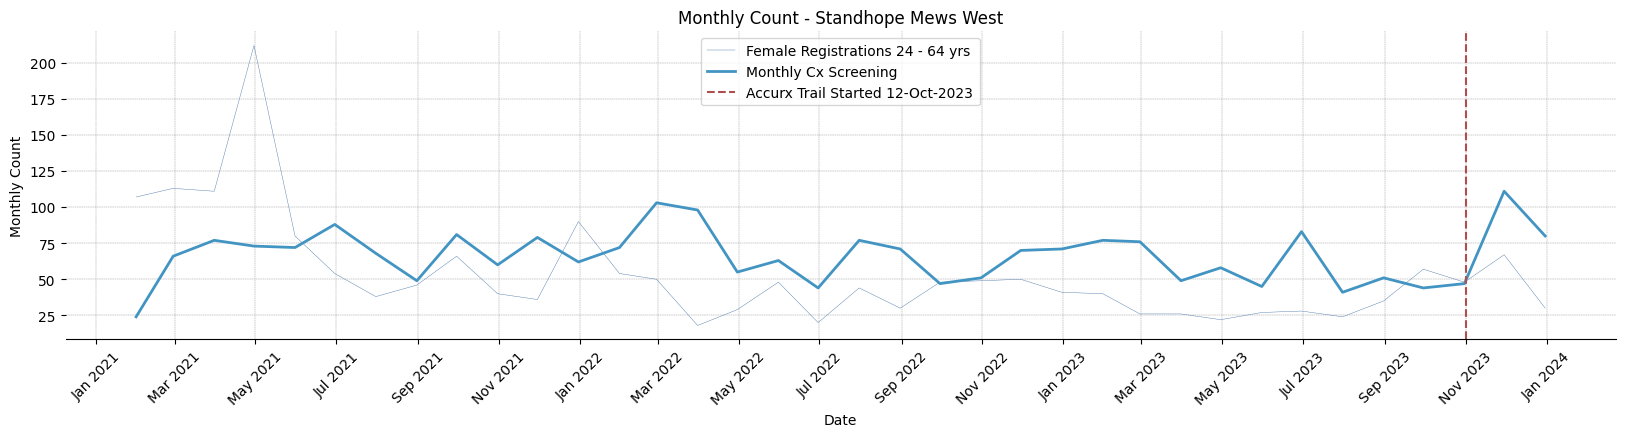

Mean Monthly ['SMW'] - Cx Screening Rate: 66.19
Mean Monthly ['SMW'] - Registrations for Females in the Cx Screening Age-group: 52.89
Mean Diff:  13.31 - Effectiveness of Screening Program


In [48]:
plot_ts(reg, data, "Monthly Count - Standhope Mews West", surgery=["SMW"])

## Patient Location

In [41]:
# @title
# prompt: generate a longitude latitude map that displays in colabs notebook

import folium
import pandas as pd

# Create a map object
m = folium.Map(location=[51.5074, -0.1278], zoom_start=12)
icon = folium.Icon(icon='cloud', prefix='fa', icon_color='blue', icon_size=(10, 10))

# Add a circle marker for each location in the data frame
for lat, lon in zip(reg['Postcode Latitude'], reg['Postcode Longitude']):
    folium.CircleMarker(location=[lat, lon], radius=5, color='red', fill=True, fill_color='red').add_to(m)

# Display the map
m
